# Introduction

In this homework, using the reviews downloaded as part of Homework 5, we will 
- Select a clustering method and run it over the collection of reviews
    - Show at least 2 different ways of clustering the reviews.
        - Changing k in k-Means clustering (OR)
        - Change where you "cut" Agnes or Diana
- Write a short phrase to characterize of what each cluster is generally centered on semantically
- Explain which of hte 2 clustering results from Question 1 is preferable and why

#### Preparation Steps
- Import the necessary packages
- Import the reviews from Homework 5
- Cleanup retain column to retain only the numeric value

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
data = pd.read_excel('Film_User_Reviews.xlsx')
data['Rating'] = data['Rating'].replace(r'\n','', regex=True).str.split('/').str[0].astype(int)
review = data['Review']

In [3]:
data

,Unnamed: 0,Film Title,Review User,Title,Review,Rating
0,0,Palm Springs,fadlanamin,Weird but Good Weird,I was expecting a conventional rom-com where t...,8
1,1,Palm Springs,kjproulx,It's Very Hard to Dislike a Movie like Palm S...,Films that revolve around characters repeating...,9
2,2,Palm Springs,cartsghammond,Pure fun,Palm Springs is just such a good time of a mov...,9
3,3,Palm Springs,cardsrock,Simply terrific,I'm impressed that people are still able to fi...,8
4,4,Palm Springs,Loptimus06,A New Take On Groundhog Day,"Palm Springs is ""One of those infinite time-lo...",8
...,...,...,...,...,...,...
120,20,Desperados,omood-00755,Great comedy film,It was a good comedy film. Was it a masterliec...,9
121,21,Desperados,Worldpeece1,Predictable and boring,The main character was just annoying. Found my...,2
122,22,Desperados,boriquachula16,Couldn't skip through fast enough.,The ONLY good thing about this film is Lamorne...,1
123,23,Desperados,Elizabethchivers,Very fun chick flick,I was surprised to see so many bad reviews. Th...,8


In [4]:
review

0      I was expecting a conventional rom-com where t...
1      Films that revolve around characters repeating...
2      Palm Springs is just such a good time of a mov...
3      I'm impressed that people are still able to fi...
4      Palm Springs is "One of those infinite time-lo...
                             ...                        
120    It was a good comedy film. Was it a masterliec...
121    The main character was just annoying. Found my...
122    The ONLY good thing about this film is Lamorne...
123    I was surprised to see so many bad reviews. Th...
124    Decent movie but was disappointed in the story...
Name: Review, Length: 125, dtype: object

#### Tokenize, Stem, remove stopwords

In [5]:
# Initialize empty array 
# to append clean text  
corpus = []  
  
# 1000 (reviews) rows to clean 
for i in range(0, 125):  
      
    # column : "Review", row ith 
    review = re.sub('[^a-zA-Z]', ' ', data['Review'][i])  
      
    # convert all cases to lower cases 
    review = review.lower()  
      
    # split to array(default delimiter is " ") 
    review = review.split()  
      
    # creating PorterStemmer object to 
    # take main stem of each word 
    ps = PorterStemmer()  
      
    # loop for stemming each word 
    # in string array at ith row     
    review = [ps.stem(word) for word in review 
                if not word in set(stopwords.words('english'))]  
                  
    # rejoin all string array elements 
    # to create back into a string 
    review = ' '.join(review)   
      
    # append each string to create 
    # array of clean text  
    corpus.append(review)  

### Tfidfvectorizer

We use the tfidfvectorizer to
- Computer word counts
- IDF values
- and tf-idf scores

In [6]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(corpus)
text = tfidf.transform(corpus)

#### Identify optimal number of clusters

Use minibatch to plot for multiple values of k and identify the elbow where the SSE begins to level off.

We could have chosen 14 or 22 clusters as the optimal value. Here I've chosen 14 as the optimal clusters and performed a comparitive analysis against 5 clusters for the purpose of this homework.

In [7]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters


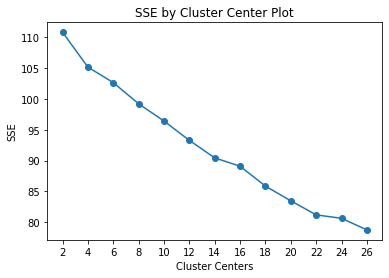

In [8]:
find_optimal_clusters(text, 26)

In [9]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=125, replace=False)
    
    pca = PCA(n_components=10).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=10).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=125, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    

In [10]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            

In [11]:
clusters = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

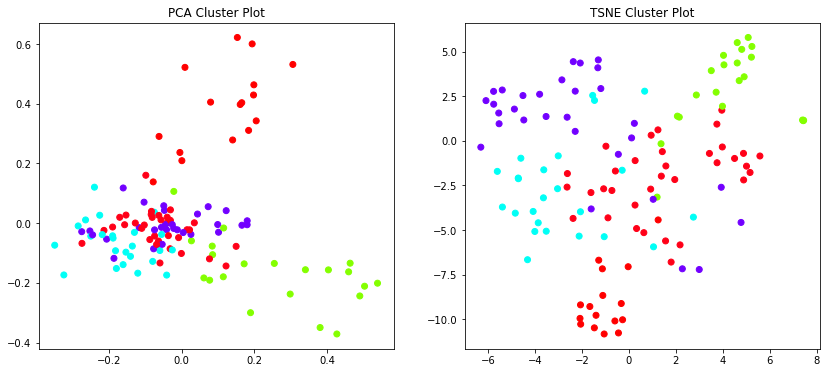

In [12]:
plot_tsne_pca(text, clusters)

In [13]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
movi,milioti,groundhog,film,time,samberg,palm,spring,loop,day

Cluster 1
movi,good,laugh,contest,film,ferrel,iceland,song,love,eurovis

Cluster 2
parent,everyth,entitl,netflix,watch,main,want,charact,movi,like

Cluster 3
time,craig,charact,murder,act,movi,mysteri,good,film,stori

Cluster 4
relat,rom,com,fun,enjoy,time,funni,expect,watch,movi


In [14]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

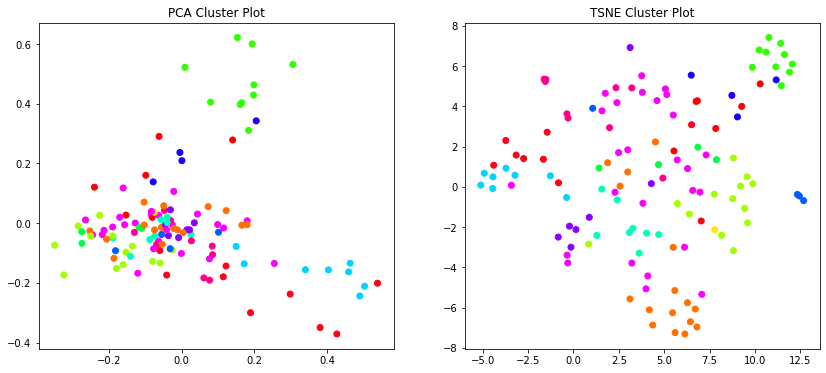

In [15]:
plot_tsne_pca(text, clusters)

In [16]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
annoy,stuck,anyth,classic,work,groundhog,alreadi,movi,day,watch

Cluster 1
movi,knive,cast,craig,johnson,good,murder,stori,film,mysteri

Cluster 2
like,make,thing,day,work,netflix,right,anoth,hous,hollywood

Cluster 3
way,stupid,entitl,self,want,main,movi,parent,charact,like

Cluster 4
groundhog,cristin,great,film,andi,milioti,spring,palm,day,samberg

Cluster 5
play,help,wast,world,messag,bad,charact,movi,act,littl

Cluster 6
million,absolut,turn,rich,movi,usual,wast,time,school,kid

Cluster 7
countri,song,laugh,hilari,love,ferrel,american,year,film,eurovis

Cluster 8
good,wrong,million,charact,cri,film,want,ok,pretti,privileg

Cluster 9
hilari,concept,romant,lead,watch,funni,end,movi,time,loop

Cluster 10
cute,romanc,premis,cast,terribl,stori,funni,origin,rom,com

Cluster 11
watch,rate,realli,funni,film,laugh,enjoy,good,recommend,movi

Cluster 12
saw,time,good,movi,mani,better,peopl,love,expect,iceland

Cluster 13
reason,good,movi,iceland,crazi,best,eurovis,love,contest,son

#### Interpretation of Cluster Center

- In the first analysis of 5 cluster, it is difficult to vind a semantic center for the clusters.
- In the second analysis with 14 clusters, it is much better defined and easier to find a semantic center.
    - The clusters seems to be centered on the emotions expressed in the reviews.
    - The other dimension seems to be the plot of the movie.
- Workds like Annoy, Stuck, Anything, murder, mysteri, stupid, great, film, etc. lead me to my inference.

#### Which clustering result is preferred?

For me the second cluster result is preferred even though there is slight overlap of the clusters. Splitting the reviews into larger number of clusters would not be advisable because we already went with 14 clusters for 125 movie reviews. If we went with the other option of 22 clusters, then we would roughly have around 5 reviews per cluster. This would make the clusters very parse. I'm satisfied with the result I got from grouping the reviews into 14 clusters.

### Reference:

- https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans